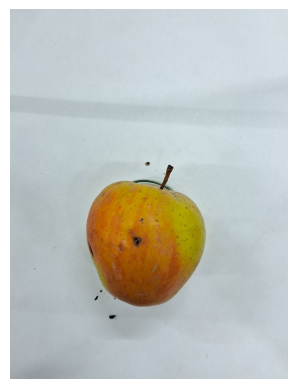

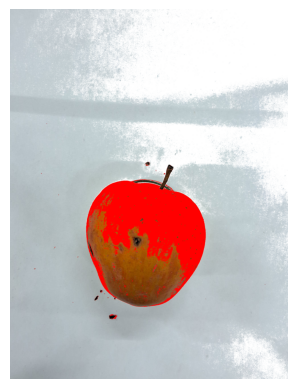

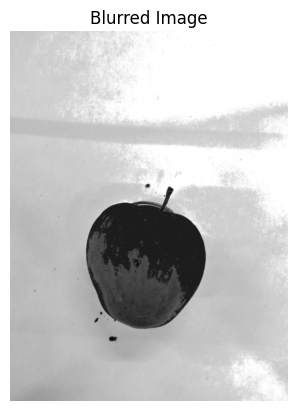

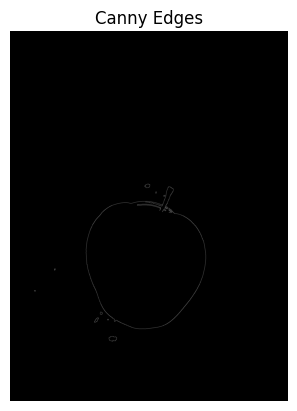

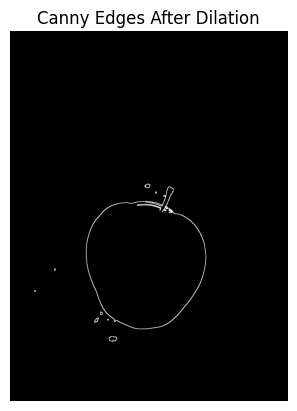

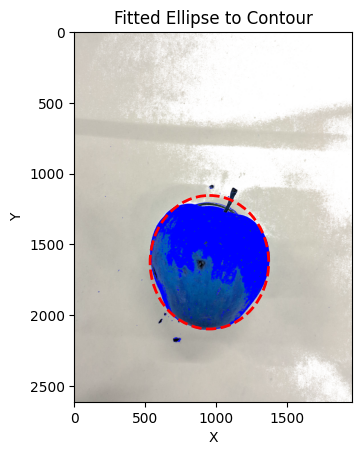

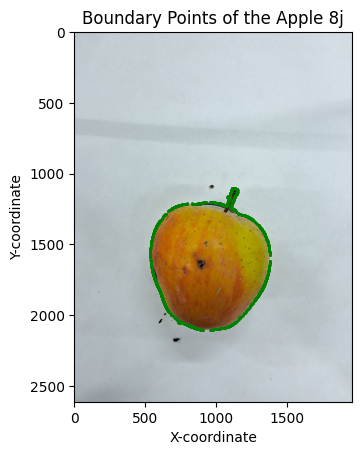

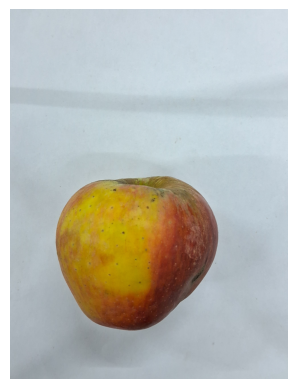

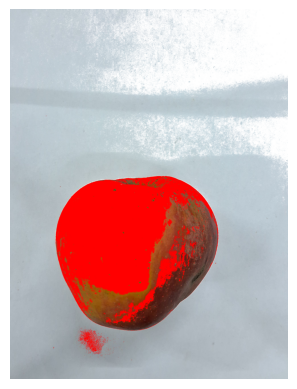

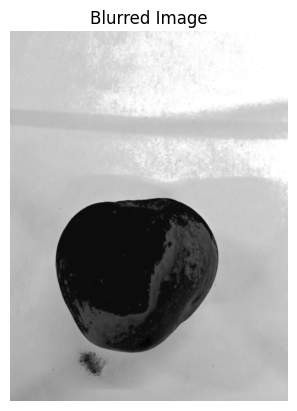

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.image import imread
from matplotlib.patches import Ellipse

def print_image(pixel_intensity, cmap, title):
    plt.imshow(pixel_intensity, cmap=cmap)  
    plt.axis('off')  
    plt.title(title)
    plt.show()

def perform_dilation(edges, no_of_interation):
    # kernal for dilation
    kernel = np.ones((4,4), np.uint8)
    return cv2.dilate(edges, kernel, iterations=1)

def fit_ellipse(max_contour):
    # Fit an ellipse to the contour
    ellipse = cv2.fitEllipse(max_contour)
    
    # Convert the ellipse parameters to Matplotlib format
    xc, yc = ellipse[0]
    a = ellipse[1][0] / 2
    b = ellipse[1][1] / 2
    theta = np.deg2rad(ellipse[2])
    
    # Plot the original image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Plot the fitted ellipse
    ellipse_patch = Ellipse((xc, yc), width=a*2, height=b*2, angle=-theta, fill=False, edgecolor='red', linestyle='--', linewidth=2)
    plt.gca().add_patch(ellipse_patch)
    
    # Set plot labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Fitted Ellipse to Contour')
    
    # Show the plot
    plt.axis('scaled')
    plt.show()
    
def find_approx_contours(edges):
    _, binary_edges = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY)

    # Find contours in the binary edge-detected image
    contours, _ = cv2.findContours(binary_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    fit_ellipse(contour)
    
    # Approximate the contour to reduce the number of points
    epsilon = 0.00001 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

def print_apple_image_with_boundary_points(image, boundary_points, apple_label):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), origin='lower')
    plt.scatter(*zip(*boundary_points), color='green', s=1)
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title(f'Boundary Points of the Apple {apple_label}')
    plt.show()

def yellow_to_red_pixels(image):
    lower_yellow = np.array([100, 100, 0])  # Lower bound for spread yellow range (decreased)
    upper_yellow = np.array([255, 255, 150])  # Upper bound for spread yellow range (increased)
    lower_red = np.array([100, 0, 0])  # Lower bound for moderate/less red range
    upper_red = np.array([255, 50, 50])  # Upper bound for moderate/less red range
    lower_white = np.array([200, 200, 200])  # Lower bound for low/moderate white range (increased)
    
    yellow_mask = np.all((image >= lower_yellow) & (image <= upper_yellow), axis=-1)
    red_mask = np.all((image >= lower_red) & (image <= upper_red), axis=-1)
    white_mask = np.all(image >= lower_white, axis=-1)
    
    # Convert yellow pixels to more red
    image_copy = np.copy(image)
    image_copy[yellow_mask] = [255, 0, 0]  # More red
    
    # Convert moderate/less red pixels to high red
    image_copy[red_mask] = [255, 0, 0]  # High red
    
    # Convert low/moderate white pixels to complete white
    image_copy[white_mask] = [255, 255, 255]  # Complete white
    
    plt.imshow(image_copy)
    plt.axis('off')
    plt.show()
    return image_copy

# Function to find the boundary points of the apple in the image
def find_boundary_points(image_path):

    # # Loading and converting image to grayscale
    # image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to smooth the image with guassian kernal of 11*11, higher the kernal size that blurring effect will be more pronounced
    blurred = cv2.GaussianBlur(gray, (13, 13), 0)
    print_image(blurred, 'gray', 'Blurred Image')
    
    # Perform Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    print_image(edges, 'gray', 'Canny Edges')
    
    # kernal for dilation
    kernel = np.ones((3,3), np.uint8)
    edges = perform_dilation(edges, 1)
    print_image(edges, 'gray', 'Canny Edges After Dilation')

    approx = find_approx_contours(edges)
    # Convert the boundary points to a list of tuples
    boundary_points = [tuple(point[0]) for point in approx]
    return boundary_points

count = 0
directory = '../Dataset_Cropped'
for filename in os.listdir(directory):
    # print(os.path.join(directory, filename))
    if os.path.isfile(os.path.join(directory, filename)):
        filename = filename[:-4]
        if len(filename) != 2 or count >= 15:
            continue
        count+=1
        image_path = f'../Dataset_Cropped/{filename}.jpg'
        image = imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        image = yellow_to_red_pixels(image)
        boundary_points = find_boundary_points(image_path)
        image = cv2.imread(image_path)
        print_apple_image_with_boundary_points(image, boundary_points, filename)